In [29]:
from collections import OrderedDict
import torch
import torchvision.transforms.v2 as transforms
import torchvision
import timm

transform = torchvision.transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (.3081, ))
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


model = timm.create_model('resnet10t', pretrained=False, in_chans=1, num_classes=10).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
model.train()
num_epochs = 100
total_step = len(train_loader)

lrs_forward = []
lrs_backward = []
weights = []

def calc_fun(i, ii, iii):
    # i - theta_i, ii - theta_i+1, iii - theta_i+2
    res = OrderedDict()
    for (ki, vi), (_, vii,), (_, viii) in zip(i.items(), ii.items(), iii.items()):
        nominator =  (vii - viii)
        denominator = (2*vii - vi - viii)
        res[ki] = torch.sum(torch.abs(nominator))/torch.sum(torch.abs(denominator))
    return res

def detach_and_copy_to_cpu(state):
    res = OrderedDict()
    for k, v in state.items():
        res[k] = v.detach().cpu()
    return res

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    weights.append(detach_and_copy_to_cpu(model.state_dict()))
    if len(weights) > 3:
        weights.pop(0)
    # +2 means 2 epochs earlier
    if epoch > 3:
        lrs_backward.append(calc_fun(weights[-1], weights[-2], weights[-3]))
        lrs_forward.append(calc_fun(weights[-3], weights[-2], weights[-1]))
    

/home/mikolaj/optinml/.venv/lib64/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Epoch [1/100], Step [100/235], Loss: 0.0752
Epoch [1/100], Step [200/235], Loss: 0.0649
Epoch [2/100], Step [100/235], Loss: 0.0537
Epoch [2/100], Step [200/235], Loss: 0.0138
Epoch [3/100], Step [100/235], Loss: 0.0305
Epoch [3/100], Step [200/235], Loss: 0.0085
Epoch [4/100], Step [100/235], Loss: 0.0108
Epoch [4/100], Step [200/235], Loss: 0.0391
Epoch [5/100], Step [100/235], Loss: 0.0136
Epoch [5/100], Step [200/235], Loss: 0.0129
Epoch [6/100], Step [100/235], Loss: 0.0025
Epoch [6/100], Step [200/235], Loss: 0.0106
Epoch [7/100], Step [100/235], Loss: 0.0041
Epoch [7/100], Step [200/235], Loss: 0.0032
Epoch [8/100], Step [100/235], Loss: 0.0023
Epoch [8/100], Step [200/235], Loss: 0.0181
Epoch [9/100], Step [100/235], Loss: 0.0018
Epoch [9/100], Step [200/235], Loss: 0.0033
Epoch [10/100], Step [100/235], Loss: 0.0063
Epoch [10/100], Step [200/235], Loss: 0.0090
Epoch [11/100], Step [100/235], Loss: 0.0106
Epoch [11/100], Step [200/235], Loss: 0.0024
Epoch [12/100], Step [100/23

KeyboardInterrupt: 

<Axes: >

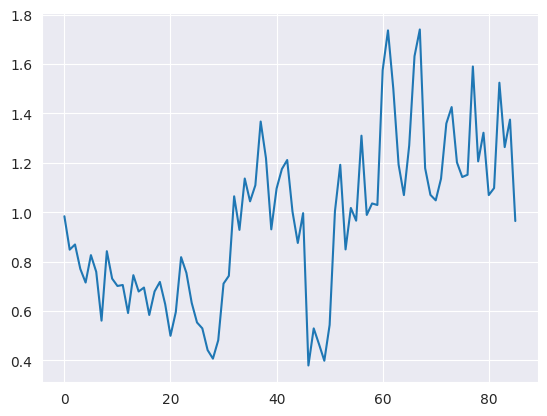

In [33]:
import seaborn as sns

ys = [lr_forward['fc.weight'].item() for lr_forward in lrs_forward]

sns.lineplot(x=list(range(86)), y=ys)

<Axes: >

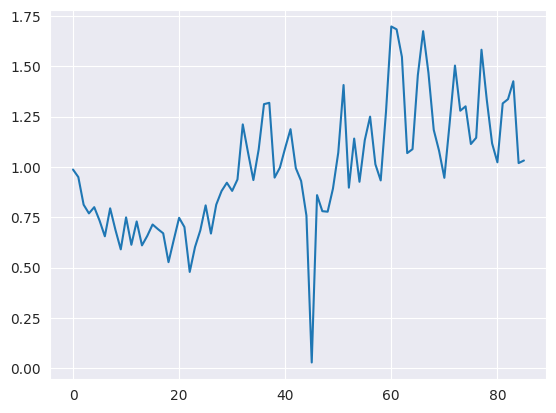

In [32]:
import seaborn as sns

ys = [lr_forward['fc.weight'].item() for lr_forward in lrs_backward]

sns.lineplot(x=list(range(86)), y=ys)

In [31]:
len(ys)

86

In [25]:
ys[0].shape

torch.Size([])

In [11]:
len(lrs_backward)

3887